# Train a Network from Scratch

In [25]:
import scipy.io as sio
import tensorflow as tf
from keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Dense, ReLU, Softmax, GlobalAveragePooling2D
from keras import Sequential
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import seaborn as sns
import cv2 as cv

sns.set_style("whitegrid")

In [3]:
# To avoid: 
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized. 
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load Training Data

In [4]:
data = sio.loadmat("../data/fashionMNIST.mat")

yTrain = data["yTrain"]
yTest = data["yTest"]
xTrain = data["xTrain"].transpose([2, 0, 1])
xTest = data["xTest"].transpose([2, 0, 1])

print("xTrain shape: ", xTrain.shape)
print("xTest shape: ", xTest.shape)
print("yTrain shape: ", yTrain.shape)
print("yTest shape: ", yTest.shape)

xTrain shape:  (60000, 28, 28)
xTest shape:  (10000, 28, 28)
yTrain shape:  (60000, 1)
yTest shape:  (10000, 1)


In [5]:
xTrain = tf.expand_dims(xTrain, axis=-1)
xTest = tf.expand_dims(xTest, axis=-1)
yTrain = tf.one_hot(yTrain[:, 0]-1, 10)
yTest = tf.one_hot(yTest[:, 0]-1, 10)

print("xTrain shape: ", xTrain.shape)
print("xTest shape: ", xTest.shape)
print("yTrain shape: ", yTrain.shape)
print("yTest shape: ", yTest.shape)

xTrain shape:  (60000, 28, 28, 1)
xTest shape:  (10000, 28, 28, 1)
yTrain shape:  (60000, 10)
yTest shape:  (10000, 10)


## Define Network Architecture

In [16]:
model = Sequential([InputLayer(input_shape=(28, 28, 1)), 
                    Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding="same"), 
                    BatchNormalization(),
                    ReLU(), 
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                    Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same"),
                    BatchNormalization(),
                    ReLU(), 
                    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same"),
                    BatchNormalization(),
                    ReLU(), 
                    GlobalAveragePooling2D(),
                    Dense(units=10), 
                    Softmax()])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_11 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 re_lu_10 (ReLU)             (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 batch_normalization_12 (Bat  (None, 14, 14, 16)      

## Specify Training Options

In [18]:
optimizer = Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Train the network

In [19]:
history = model.fit(xTrain, yTrain, epochs=25, batch_size=64, validation_data=(xTest, yTest))

Epoch 1/25
938/938 [==============================] - 29s 28ms/step - loss: 1.6969 - categorical_accuracy: 0.4811 - val_loss: 1.3213 - val_categorical_accuracy: 0.6640
Epoch 2/25
938/938 [==============================] - 26s 27ms/step - loss: 1.1598 - categorical_accuracy: 0.7011 - val_loss: 1.0176 - val_categorical_accuracy: 0.7286
Epoch 3/25
938/938 [==============================] - 25s 27ms/step - loss: 0.9320 - categorical_accuracy: 0.7373 - val_loss: 0.8494 - val_categorical_accuracy: 0.7500
Epoch 4/25
938/938 [==============================] - 31s 33ms/step - loss: 0.8001 - categorical_accuracy: 0.7545 - val_loss: 0.7499 - val_categorical_accuracy: 0.7654
Epoch 5/25
938/938 [==============================] - 26s 27ms/step - loss: 0.7188 - categorical_accuracy: 0.7694 - val_loss: 0.6934 - val_categorical_accuracy: 0.7729
Epoch 6/25
938/938 [==============================] - 25s 27ms/step - loss: 0.6627 - categorical_accuracy: 0.7826 - val_loss: 0.6386 - val_categorical_accuracy:

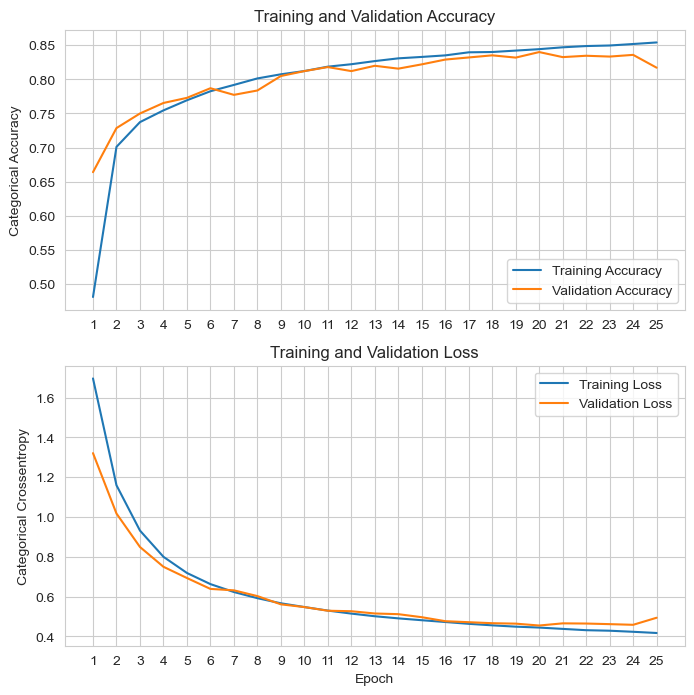

In [22]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Categorical Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks(range(len(acc)), range(1, len(acc)+1))

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Crossentropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(loss)), range(1, len(loss)+1))

plt.show()

## Test network with new image

In [69]:
labels_dict = dict()
for i, j in zip(range(1, 11), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']):
    labels_dict[i] = j

def predict_new_images(image_path, model, labels_dict):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image_preprocessed = cv.resize(image, (28, 28))
    image_preprocessed = cv.cvtColor(image_preprocessed, cv.COLOR_BGR2GRAY)
    image_preprocessed = tf.expand_dims(tf.expand_dims(image_preprocessed, axis=-1), axis=0)

    image_prediction = model.predict(image_preprocessed, verbose=False)
    image_prediction = labels_dict[tf.argmax(image_prediction, axis=-1).numpy()[0] + 1]

    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    plt.title("Prediction: "+ image_prediction)
    plt.show()

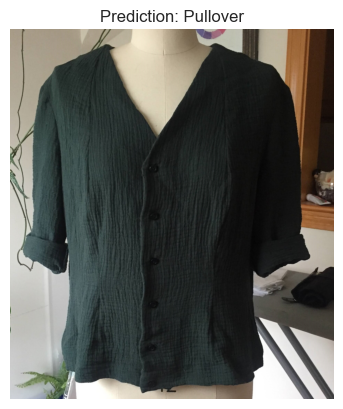

In [70]:
predict_new_images("../data/shirtexample.jpg", model, labels_dict)

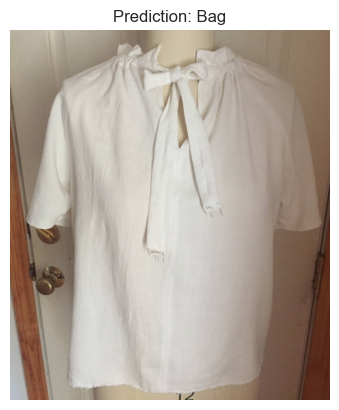

In [71]:
predict_new_images("../data/shirtexamplebow.jpg", model, labels_dict)

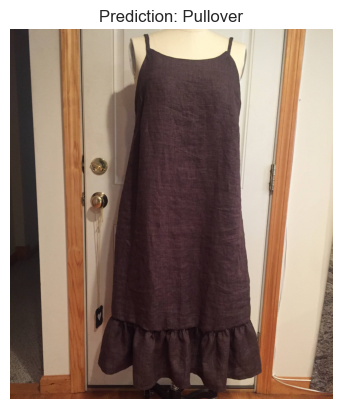

In [72]:
predict_new_images("../data/dressexample.jpg", model, labels_dict)